<!-- LIBRARY -->

# LIBRARY

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


2025-04-12 09:14:56.247603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744449296.461907      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744449296.525067      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# SELEKSI DATA

In [2]:
# Baca data CSV langsung dari path Kaggle
df = pd.read_csv('/kaggle/input/bot-iot/data_1.csv')

# Jika datanya sudah terpisah kolom (tidak perlu split manual):
df.columns = df.columns.str.strip()  # Hilangkan spasi yang tidak diinginkan
df.head()


/tmp/ipykernel_19/1311780644.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/bot-iot/data_1.csv')


,pkSeqID,stime,flgs,proto,saddr,sport,daddr,dport,pkts,bytes,...,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category,subcategory
0,1,1.526344e+09,e,arp,192.168.100.1,NaN,192.168.100.3,NaN,4,240,...,2,2,120,120,0.002508,0.000836,0.000836,0,Normal,Normal
1,2,1.526344e+09,e,tcp,192.168.100.7,139,192.168.100.4,36390,10,680,...,5,5,350,330,0.006190,0.002751,0.002751,0,Normal,Normal
2,3,1.526344e+09,e,udp,192.168.100.149,51838,27.124.125.250,123,2,180,...,1,1,90,90,20.590960,0.000000,0.000000,0,Normal,Normal
3,4,1.526344e+09,e,arp,192.168.100.4,NaN,192.168.100.7,NaN,10,510,...,5,5,210,300,0.006189,0.002751,0.002751,0,Normal,Normal
4,5,1.526344e+09,e,udp,192.168.100.27,58999,192.168.100.1,53,4,630,...,2,2,174,456,0.005264,0.001755,0.001755,0,Normal,Normal


In [3]:
# Tampilkan jumlah data untuk setiap kategori di kolom 'category'
if 'category' in df.columns:
    category_counts = df['category'].value_counts()
    total = category_counts.sum()
    print("\nDistribusi Kategori:")
    for label, count in category_counts.items():
        percentage = (count / total) * 100
        print(f"{label:<16}: {count:>6,} data (≈ {percentage:.2f}%)")
else:
    print("Kolom 'category' tidak ditemukan dalam dataset.")


Distribusi Kategori:
Reconnaissance  : 998,007 data (≈ 99.80%)
Normal          :  1,993 data (≈ 0.20%)


In [4]:
# Ambil seluruh data Normal
df_normal = df[df['category'] == 'Normal']

# Ambil 2000 data Reconnaissance secara acak
df_recon = df[df['category'] == 'Reconnaissance'].sample(n=2000, random_state=42)

# Gabungkan keduanya
df_balanced = pd.concat([df_normal, df_recon]).sample(frac=1, random_state=42).reset_index(drop=True)

# Tampilkan hasil akhir
print("Distribusi setelah balancing:")
print(df_balanced['category'].value_counts())


Distribusi setelah balancing:
category
Reconnaissance    2000
Normal            1993
Name: count, dtype: int64


# DATA PREPROCESSING

In [5]:
# Hapus kolom yang tidak digunakan dan mengandung banyak NaN
df_balanced = df_balanced.drop(columns=[
    'subcategory', 'sport', 'dport', 'smac', 'dmac', 'soui', 'doui', 'sco', 'dco'
], errors='ignore')

# Daftar fitur numerik untuk model
numeric_columns = ['pkts', 'bytes', 'dur', 'rate', 'srate', 'drate', 'spkts', 'dpkts', 'sbytes', 'dbytes']

# Bersihkan nilai kosong
df_balanced.replace('', np.nan, inplace=True)

# Ubah ke numerik (coerce akan menjadikan string/error jadi NaN)
for col in numeric_columns:
    df_balanced[col] = pd.to_numeric(df_balanced[col], errors='coerce')

# Buang baris yang tidak memiliki data valid di kolom numerik atau label
df_balanced.dropna(subset=numeric_columns + ['category'], inplace=True)

# Tampilkan info jumlah data setelah bersih
print("Dataset shape after cleaning:", df_balanced.shape)
print("\nCek NaN lagi jika masih ada:")
print(df_balanced[numeric_columns + ['category']].isnull().sum())


Dataset shape after cleaning: (3993, 26)

Cek NaN lagi jika masih ada:
pkts        0
bytes       0
dur         0
rate        0
srate       0
drate       0
spkts       0
dpkts       0
sbytes      0
dbytes      0
category    0
dtype: int64


In [6]:
df_balanced

,pkSeqID,stime,flgs,proto,saddr,daddr,pkts,bytes,state,ltime,...,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category
0,670054,1.526899e+09,e,tcp,192.168.100.149,192.168.100.3,2,120,RST,1.526899e+09,...,0.050273,1,1,60,60,19.891392,0.000000,0.0,1,Reconnaissance
1,137995,1.526356e+09,e,udp,192.168.100.7,192.168.159.152,2,176,INT,1.526356e+09,...,0.000000,2,0,176,0,0.198087,0.198087,0.0,0,Normal
2,785313,1.526902e+09,e,arp,192.168.100.1,192.168.100.3,2,120,CON,1.526902e+09,...,0.000010,1,1,60,60,100000.000000,0.000000,0.0,0,Normal
3,118075,1.526354e+09,e,udp,192.168.100.7,192.168.159.152,2,176,INT,1.526354e+09,...,0.000000,2,0,176,0,0.198207,0.198207,0.0,0,Normal
4,727108,1.526899e+09,e,tcp,192.168.100.149,192.168.100.3,2,120,RST,1.526899e+09,...,0.067661,1,1,60,60,14.779562,0.000000,0.0,1,Reconnaissance
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,138168,1.526356e+09,e,udp,192.168.100.3,192.33.4.12,2,1290,CON,1.526356e+09,...,0.176191,1,1,81,1209,5.675659,0.000000,0.0,0,Normal
3989,440024,1.526882e+09,e,arp,192.168.100.150,192.168.100.1,2,120,CON,1.526882e+09,...,0.000143,1,1,60,60,6993.007324,0.000000,0.0,0,Normal
3990,120481,1.526355e+09,eU,udp,192.168.100.3,205.251.195.162,2,419,CON,1.526355e+09,...,0.288045,1,1,118,301,3.471680,0.000000,0.0,0,Normal
3991,418580,1.526881e+09,e,tcp,192.168.100.149,192.168.100.3,2,120,RST,1.526881e+09,...,0.009184,1,1,60,60,108.885017,0.000000,0.0,1,Reconnaissance


In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode 'category' ke bentuk numerik
le = LabelEncoder()
df_balanced['label'] = le.fit_transform(df_balanced['category'])

# Cek hasil encoding
print(dict(zip(le.classes_, le.transform(le.classes_))))


{'Normal': 0, 'Reconnaissance': 1}


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Fitur dan label
X_raw = df_balanced[numeric_columns]
y_raw = df_balanced['label']



In [9]:
X_raw

,pkts,bytes,dur,rate,srate,drate,spkts,dpkts,sbytes,dbytes
0,2,120,0.050273,19.891392,0.000000,0.0,1,1,60,60
1,2,176,5.048292,0.198087,0.198087,0.0,2,0,176,0
2,2,120,0.000010,100000.000000,0.000000,0.0,1,1,60,60
3,2,176,5.045218,0.198207,0.198207,0.0,2,0,176,0
4,2,120,0.067661,14.779562,0.000000,0.0,1,1,60,60
...,...,...,...,...,...,...,...,...,...,...
3988,2,1290,0.176191,5.675659,0.000000,0.0,1,1,81,1209
3989,2,120,0.000143,6993.007324,0.000000,0.0,1,1,60,60
3990,2,419,0.288045,3.471680,0.000000,0.0,1,1,118,301
3991,2,120,0.009184,108.885017,0.000000,0.0,1,1,60,60


In [10]:
y_raw

0       1
1       0
2       0
3       0
4       1
       ..
3988    0
3989    0
3990    0
3991    1
3992    1
Name: label, Length: 3993, dtype: int64

In [11]:
# Normalisasi fitur
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

# Train-test split
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_scaled, y_raw, test_size=0.2, random_state=42, stratify=y_raw)


In [12]:
X_train_raw

array([[1.37553474e-05, 1.94529377e-06, 7.42315548e-05, ...,
        2.75103164e-05, 5.82828160e-07, 3.76094889e-06],
       [1.37553474e-05, 8.16207176e-07, 7.36271833e-07, ...,
        2.75103164e-05, 4.76859404e-07, 1.62343118e-06],
       [1.37553474e-05, 8.16207176e-07, 3.05679043e-05, ...,
        2.75103164e-05, 4.76859404e-07, 1.62343118e-06],
       ...,
       [3.95562525e-01, 3.89118174e-01, 3.53957123e-01, ...,
        3.95570839e-01, 3.75868715e-01, 3.90069358e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.76859404e-07, 0.00000000e+00],
       [0.00000000e+00, 3.12879417e-07, 0.00000000e+00, ...,
        0.00000000e+00, 1.08617975e-06, 0.00000000e+00]])

In [13]:
y_train_raw

2964    0
228     1
574     1
3035    1
1639    0
       ..
1807    1
3152    1
36      0
3434    1
187     0
Name: label, Length: 3194, dtype: int64

In [14]:
import numpy as np

def create_sequences(X, y, seq_length):
    sequences, labels = [], []
    for i in range(len(X) - seq_length):
        sequences.append(X[i:i + seq_length])
        labels.append(y[i + seq_length - 1])
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 10

# Convert y to array for indexing
y_train_raw = y_train_raw.to_numpy()
y_test_raw = y_test_raw.to_numpy()

X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, SEQ_LENGTH)


# MODELLING

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# MODEL
model = Sequential([
    Input(shape=(SEQ_LENGTH, X_train_seq.shape[2])),  # Gunakan Input layer resmi
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# KOMPILE MODEL
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Menampilkan arsitektur model
print("\nModel Architecture Summary:")
model.summary()
# CALLBACKS
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',   # gunakan ekstensi .keras sesuai versi Keras baru
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# TRAINING
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)


I0000 00:00:1744449314.544764      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744449314.545477      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1744449319.582074      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5223 - loss: 0.6931
Epoch 1: val_loss improved from inf to 0.69183, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5222 - loss: 0.6931 - val_accuracy: 0.5222 - val_loss: 0.6918
Epoch 2/100
 98/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5261 - loss: 0.6922
Epoch 2: val_loss improved from 0.69183 to 0.68917, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5260 - loss: 0.6922 - val_accuracy: 0.5615 - val_loss: 0.6892
Epoch 3/100
 92/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5290 - loss: 0.6898
Epoch 3: val_loss improved from 0.68917 to 0.68146, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5295 - loss: 0.6896 - val_accuracy: 0.5665 - val_loss: 0.6815
Epoch 4/100
 92/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5610 - loss: 0.6777
Epoch 4: val_loss improved from 0.68146 to 0.65686, saving mo

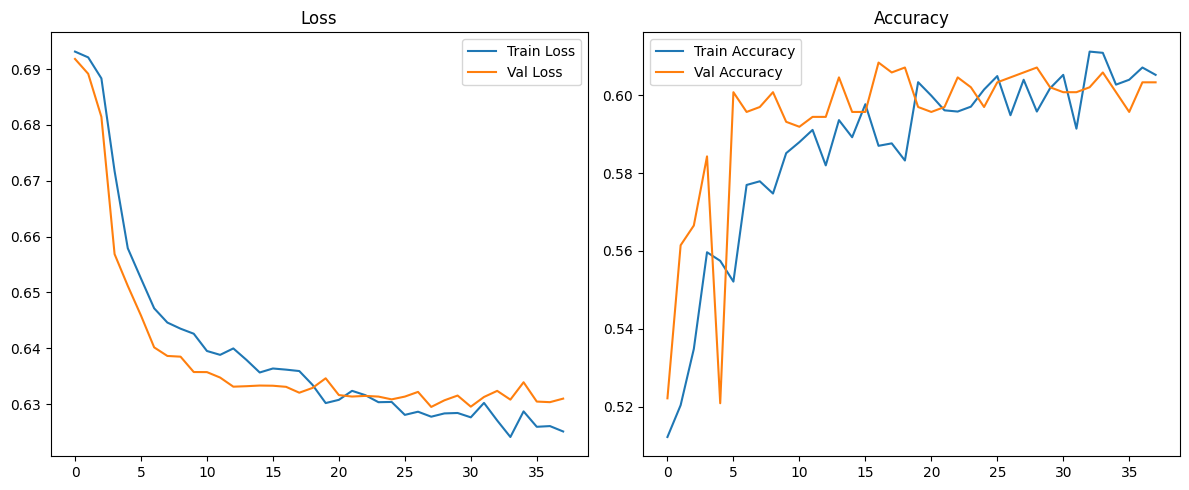

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# EVALUASI MODEL

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred = model.predict(X_test_seq)
y_pred_classes = (y_pred > 0.5).astype(int)

# Laporan klasifikasi
print("Classification Report:")
print(classification_report(y_test_seq, y_pred_classes, target_names=le.classes_))



25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Classification Report:
                precision    recall  f1-score   support

        Normal       0.86      0.25      0.38       391
Reconnaissance       0.56      0.96      0.71       398

      accuracy                           0.61       789
     macro avg       0.71      0.60      0.55       789
  weighted avg       0.71      0.61      0.55       789



# VISUALISASI

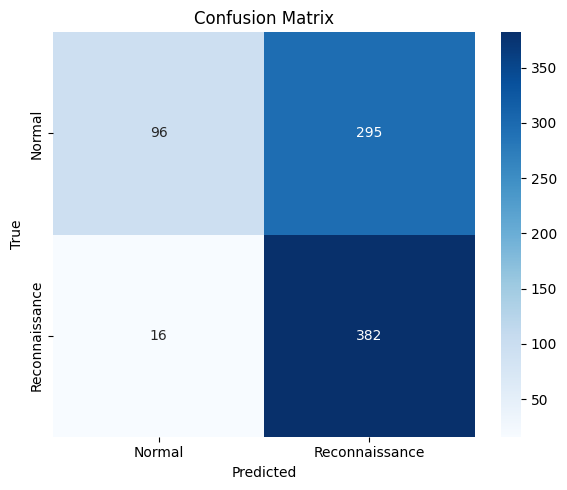

In [18]:
# Confusion matrix
cm = confusion_matrix(y_test_seq, y_pred_classes)

# Plot matrix dengan warna biru
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


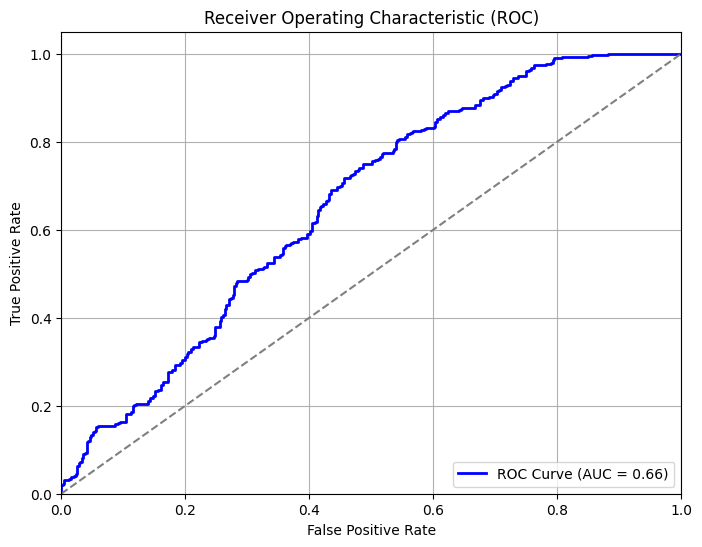

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prediksi probabilitas (bukan kelas!)
y_pred_proba = model.predict(X_test_seq).ravel()

# Hitung fpr, tpr
fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # garis random
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# UJI COBA MODEL

In [20]:
import numpy as np

# Ambil 10 sampel acak dari data uji
num_samples = 10
indices = np.random.choice(len(X_test_seq), size=num_samples, replace=False)
X_sample = X_test_seq[indices]
y_true_sample = y_test_seq[indices]

# Prediksi probabilitas
y_pred_prob = model.predict(X_sample)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Tampilkan hasil
print(f"{'Sample':<8} {'True Label':<15} {'Predicted':<15} {'Confidence':<12}")
print("-" * 50)
for i in range(num_samples):
    true_label = le.inverse_transform([y_true_sample[i]])[0]
    predicted_label = le.inverse_transform([y_pred_class[i][0]])[0]
    confidence = y_pred_prob[i][0]
    print(f"{i+1:<8} {true_label:<15} {predicted_label:<15} {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sample   True Label      Predicted       Confidence  
--------------------------------------------------
1        Normal          Reconnaissance  0.5323
2        Reconnaissance  Reconnaissance  0.5304
3        Reconnaissance  Normal          0.4691
4        Reconnaissance  Reconnaissance  0.5156
5        Normal          Reconnaissance  0.5701
6        Normal          Reconnaissance  0.5587
7        Reconnaissance  Reconnaissance  0.5902
8        Normal          Normal          0.0022
9        Reconnaissance  Reconnaissance  0.5292
10       Normal          Reconnaissance  0.5306


# SAVE MODEL

In [21]:
# Simpan seluruh model ke format Keras (.keras)
model.save('final_model.keras')


In [22]:
# Simpan model lengkap (jika versi Keras kamu masih izinkan)
model.save('model_full.h5')
